In [113]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

import pandas as pd
from scipy.spatial import distance_matrix
import numpy as np
import matplotlib.pyplot as plt
import itertools
import copy
from TrackReconstruction_functions import *


# hits = pd.read_hdf("/Users/mistryk2/Packages/nexus/ATPC_2nuBB_slim.h5","hits")

# hits = pd.read_hdf('../../NEXT_nudobe/files/data/Leptoquark_SM_nexus.h5',"MC/hits")
hits = pd.read_hdf('../../NEXT_nudobe/files/data/Leptoquark_SM_1mm_smear.h5',"MC/hits")
# hits = pd.read_hdf('../../NEXT_nudobe/files/data/Leptoquark_SM_4mm_smear.h5',"MC/hits")

# hits = pd.read_hdf("/Users/mistryk2/Packages/nexus/ATPC_eminus_0.1mmstep_slim.h5","MC/hits")
# hits = pd.read_hdf("/Users/mistryk2/Packages/nexus/ATPC_eminus_0.1mmstep_slim_smear.h5","hits")
# hits = pd.read_hdf("/Users/mistryk2/Packages/nexus/ATPC_eminus_0.1mmstep_slim_smear_1mmbin.h5","hits")

# hits = pd.read_hdf("/Users/mistryk2/Packages/nexus/ATPC_eminus_1mmstep_high_E_slim_smear.h5","hits")

display(hits)


,event_id,x,y,z,energy
0,2100,-1.558387,-0.474033,-0.086901,0.000325
1,2100,-1.979367,-0.560741,-0.082932,0.001025
2,2100,-0.967504,-0.288035,-0.075185,0.002775
3,2100,-3.083423,-0.601927,-0.062578,0.001825
4,2100,-4.089310,-0.762992,-0.004363,0.003475
...,...,...,...,...,...
3515331,1174,-85.296150,-30.598433,42.653698,0.001800
3515332,1174,-85.266411,-30.374844,43.062641,0.002325
3515333,1174,-83.992989,-30.181173,43.135872,0.004200
3515334,1174,-84.381462,-30.202492,43.557297,0.001325


,x,y,z,energy
0,-269.449677,-167.952820,-157.358719,0.024525
1,-269.405884,-167.860870,-157.533630,0.004925
2,-251.645477,-190.339462,-194.895493,0.013125
3,-251.552597,-190.616592,-194.994522,0.002825
4,-251.375610,-190.356812,-195.312500,0.054525
...,...,...,...,...
868,0.414725,-2.003453,-5.397374,0.002275
869,0.563573,-2.203699,-4.467825,0.000500
870,0.767031,-2.312121,-5.079680,0.008000
871,0.814471,-3.335512,-4.060148,0.012600


{0: [1], 1: [0], 2: [3], 3: [2, 5], 4: [5], 5: [4, 3], 6: [7, 10], 7: [6, 8], 8: [7, 15], 9: [14, 11], 14: [9, 18], 10: [12, 6], 12: [10, 19], 11: [13, 9], 13: [11, 16], 16: [13, 17], 18: [14, 20], 15: [17, 8], 17: [15, 16], 19: [12, 21], 20: [18, 22], 21: [23, 19], 23: [21, 24], 22: [20, 25], 24: [23, 26], 25: [27, 22], 27: [25, 28], 26: [30, 24], 30: [26, 35], 28: [27, 29], 29: [31, 28], 31: [29, 32], 32: [31, 33], 33: [32, 34], 34: [36, 33], 36: [34, 37], 35: [38, 30], 38: [35, 40], 37: [36, 39], 40: [38, 45], 39: [37, 43], 41: [44, 42], 44: [41, 46], 42: [43, 41], 43: [42, 39], 45: [48, 40], 48: [45, 50], 46: [44, 49], 47: [52], 52: [47], 50: [48, 53], 49: [51, 46], 51: [49, 54], 53: [50, 55], 54: [58, 51], 58: [54, 63], 55: [56, 53], 56: [55, 61], 61: [56, 62], 57: [60, 59], 60: [57, 67], 63: [58, 74], 59: [57, 64], 62: [61, 65], 64: [59, 68], 65: [62, 71], 66: [70, 75], 70: [66, 73], 67: [60, 86], 68: [64, 79], 69: [72, 75], 72: [69, 77], 71: [65, 82], 73: [81, 70], 81: [73, 91],

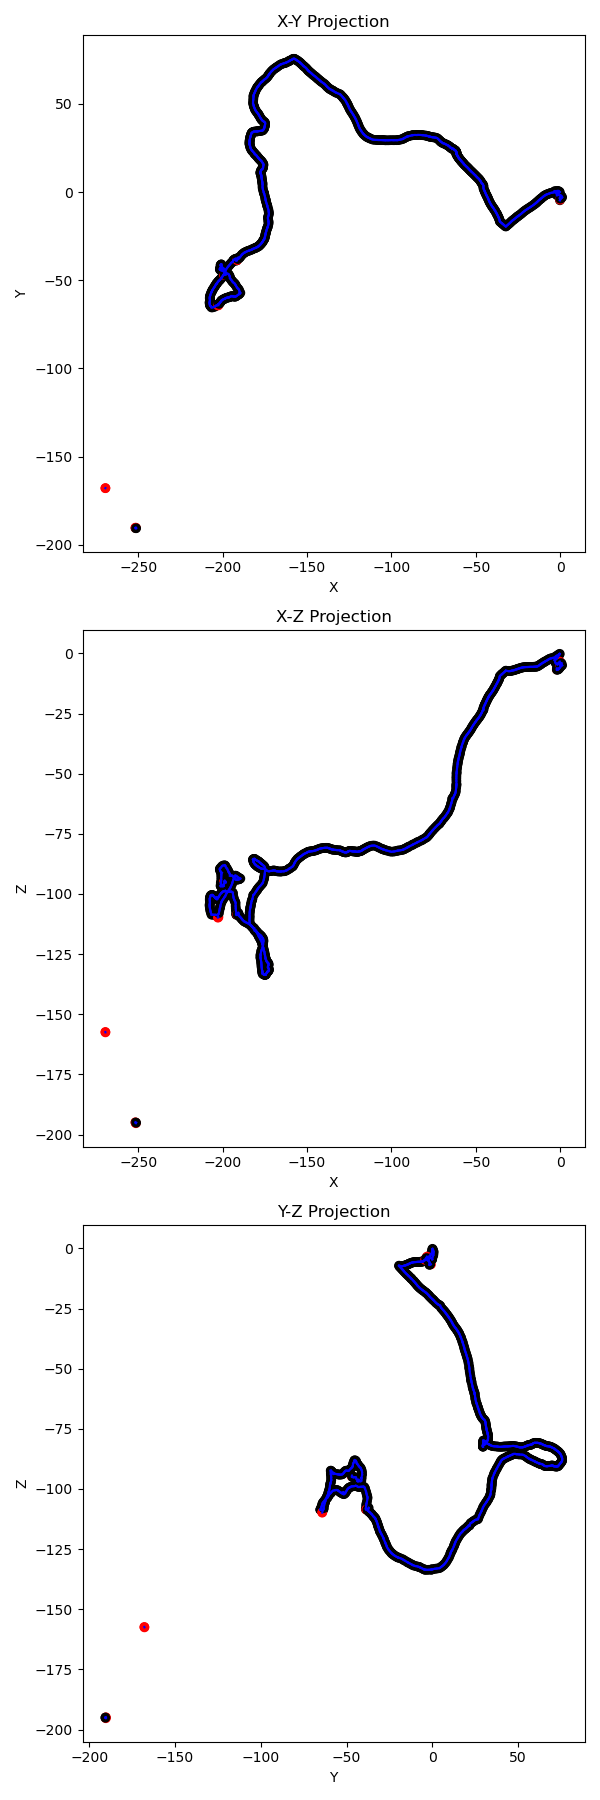

In [114]:
%matplotlib widget

data = hits[hits.event_id ==1801]

# There seems to be a duplicate row sometimes
data = data.drop_duplicates()

# display(data)
data = data[['x', 'y', 'z',"energy"]]

# shuffle the data to ensure we dont use g4 ordering
data = data.sample(frac=1).reset_index(drop=True)

# then sort it based on the x,y,z
data = data.sort_values(by=['x', "y", "z"]).reset_index(drop=True)

display(data)

df = pd.DataFrame(data)

# Calculate the distance matrix
dist_matrix = distance_matrix(data[['x', 'y', 'z']], data[['x', 'y', 'z']])

# Initialize connections counter, keeps track of number of connections to each index
connection_count = np.zeros(len(data), dtype=int)

# This is a dict, format is
# index : [connected node 1, connected node 2,...]
connected_nodes = {}

# Tunable parameters
init_dist_thresh = 15 # max distance for initial connections [mm]
incr_dist_thresh = [2,4,6,8,10,12,14,16,18,20] # Second stage, look for closest nodes, then slowly increase threshold [mm]
dist_threshold = 15 # Third distance threshold for conecting end nodes [mm]

# Function to calculate the angle between two vectors
def calculate_angle(v1, v2):
    dot_product = np.dot(v1, v2)
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    angle = np.arccos(dot_product / (norm_v1 * norm_v2))
    return angle

# Function to add connections made
# current and current node index is input
def UpdateConnections(curr_node_idx, conn_node_idx, connected_nodes_, connections_, connection_count_):

    # We shouldnt be doing any self connection
    if (curr_node_idx == conn_node_idx):
        return

    # Add connection between node i and closest_idx
    connections_.append((curr_node_idx, conn_node_idx))
    connection_count_[curr_node_idx] += 1
    connection_count_[conn_node_idx] += 1
    
    # Update connected nodes
    if i in connected_nodes_:
        connected_nodes_[curr_node_idx].append(conn_node_idx)
    else:
        connected_nodes_[curr_node_idx] = [conn_node_idx]
    
    if conn_node_idx in connected_nodes_:
        connected_nodes_[conn_node_idx].append(curr_node_idx)
    else:
        connected_nodes_[conn_node_idx] = [curr_node_idx]

# Function to check if a new connection would form a closed loop
def forms_cycle(node, target, connections_dict):

    query = node
    prev_node = node 
    # print(query)

    for index,n in enumerate(range(len(connections_dict))):
        
        # Get the connected nodes
        con_nodes = connections_dict[query]
        # print("Start",query, prev_node, con_nodes)

        # We hit a end-point and it didnt loop
        if (len(con_nodes) == 1):
            return False

        # Get the node that went in the query before
        if con_nodes[1] == prev_node:
            prev_node = query
            query = con_nodes[0]
        else:
            prev_node = query
            query = con_nodes[1]

        if (index == 0):
            query = con_nodes[0]
            prev_node = node


        # If the returned query value is the target then we have looped
        if (query == target):
            return True

    # We looped over everything and found no loops
    return False
    

# Find closest nodes and create connections
connections = []
for i in range(len(data)):
    # Find the index of the closest node (excluding itself)
    # closest_idx = np.argpartition(dist_matrix[i], 1)[1]
    closest_idx = np.argsort(dist_matrix[i])[1]
    
    # Check if the connection already exists 
    if closest_idx not in connected_nodes.get(i, []) and i not in connected_nodes.get(closest_idx, []):

        # Check the proposed node has 0 or 1 connection
        if (connection_count[closest_idx] <= 1 and connection_count[i] <= 1 and dist_matrix[i][closest_idx] < init_dist_thresh):
            # Add connection between node i and closest_idx
            UpdateConnections(i, closest_idx, connected_nodes, connections, connection_count)

# Get indices where the value is 1
single_nodes = np.where(connection_count == 1)[0]

# Incrementally loop over distance steps looking for connections
# starting from a small step size helps lock onto the nearest nodes
for dist in incr_dist_thresh:

    # Connect single nodes to the next closest single node
    for i in single_nodes:
        
        # Connections get updated, so this ensures we dont make a connection to a newly formed connection
        if connection_count[i] == 1:
            
            # Find the index of the closest node with one connection (excluding itself)
            sorted_indices = np.argsort(dist_matrix[i])[1:]
            
            for closest_idx in sorted_indices[:dist]:

                # Check if the index is not itelf and the connection count of the closest index is 1
                if closest_idx != i and connection_count[closest_idx] <= 1 and connection_count[i] <= 1 and closest_idx not in connected_nodes.get(i, []) and i not in connected_nodes.get(closest_idx, []): 
                    
                    if dist_matrix[i][closest_idx] < dist:

                        # Temporarily add the connection to check for cycles
                        temp_connections_dict = copy.deepcopy(connected_nodes)
                        temp_connections      = copy.deepcopy(connections)
                        temp_connection_count = copy.deepcopy(connection_count)

                        # print(i,closest_idx,connection_count[i], connection_count[closest_idx], temp_connections_dict[i], temp_connections_dict[closest_idx])
                        UpdateConnections(i, closest_idx, temp_connections_dict, temp_connections, temp_connection_count)

                        # Check for cycles
                        cycle = forms_cycle(i, closest_idx, temp_connections_dict)

                        temp_connections_dict = {}
                        temp_connections = []
                        temp_connection_count = []
                        
                        if not cycle:
                            UpdateConnections(i, closest_idx, connected_nodes, connections, connection_count)
                            break

print(connected_nodes)

# Function to plot connections
def plot_connections(ax, x, y, connections, connection_count, x_label, y_label):
    colors = ['r' if count == 1 or count == 0 else 'k' for count in connection_count]
    ax.scatter(x, y, c=colors, marker='o')
    for connection in connections:
        start_node = connection[0]
        end_node = connection[1]
        ax.plot([x[start_node], x[end_node]], [y[start_node], y[end_node]], 'b-')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(f'{x_label}-{y_label} Projection')

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(6, 18))

# Plot xy projection
plot_connections(axs[0], data['x'], data['y'], connections, connection_count, 'X', 'Y')

# Plot xz projection
plot_connections(axs[1], data['x'], data['z'], connections, connection_count, 'X', 'Z')

# Plot yz projection
plot_connections(axs[2], data['y'], data['z'], connections, connection_count, 'Y', 'Z')

plt.tight_layout()
plt.show()

# # Plot in 3D
# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(111, projection='3d')
# colors = ['r' if count == 1 or count == 0 else 'k' for count in connection_count]
# ax.scatter(data['x'], data['y'], data['z'], c=colors, marker='o')
# for connection in connections:
#     start_node = connection[0]
#     end_node = connection[1]
#     ax.plot([data['x'][start_node], data['x'][end_node]],
#             [data['y'][start_node], data['y'][end_node]],
#             [data['z'][start_node], data['z'][end_node]], 'b-')
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# ax.set_title('3D Projection')
# plt.show()

[{'id': 0, 'start': 0, 'end': 1, 'nodes': [0, 1], 'length': 0.202, 'energy': 0.029, 'label': 'track', 'c': (0.10588235294117647, 0.6196078431372549, 0.4666666666666667)}, {'id': 2, 'start': 2, 'end': 4, 'nodes': [2, 3, 5, 4], 'length': 1.06, 'energy': 0.113, 'label': 'track', 'c': (0.8509803921568627, 0.37254901960784315, 0.00784313725490196)}, {'id': 4, 'start': 47, 'end': 52, 'nodes': [47, 52], 'length': 0.377, 'energy': 0.083, 'label': 'track', 'c': (0.4588235294117647, 0.4392156862745098, 0.7019607843137254)}, {'id': 6, 'start': 101, 'end': 841, 'nodes': [101, 107, 116, 117, 113, 108, 104, 102, 97, 96, 98, 93, 90, 91, 81, 73, 70, 66, 75, 69, 72, 77, 76, 80, 78, 87, 79, 68, 64, 59, 57, 60, 67, 86, 92, 103, 111, 114, 120, 123, 125, 128, 129, 132, 134, 138, 136, 141, 144, 146, 148, 153, 157, 160, 163, 165, 171, 178, 182, 185, 191, 193, 199, 196, 192, 194, 189, 187, 181, 176, 169, 164, 161, 158, 154, 150, 147, 145, 142, 139, 137, 133, 130, 126, 122, 119, 115, 110, 106, 100, 94, 88, 83,

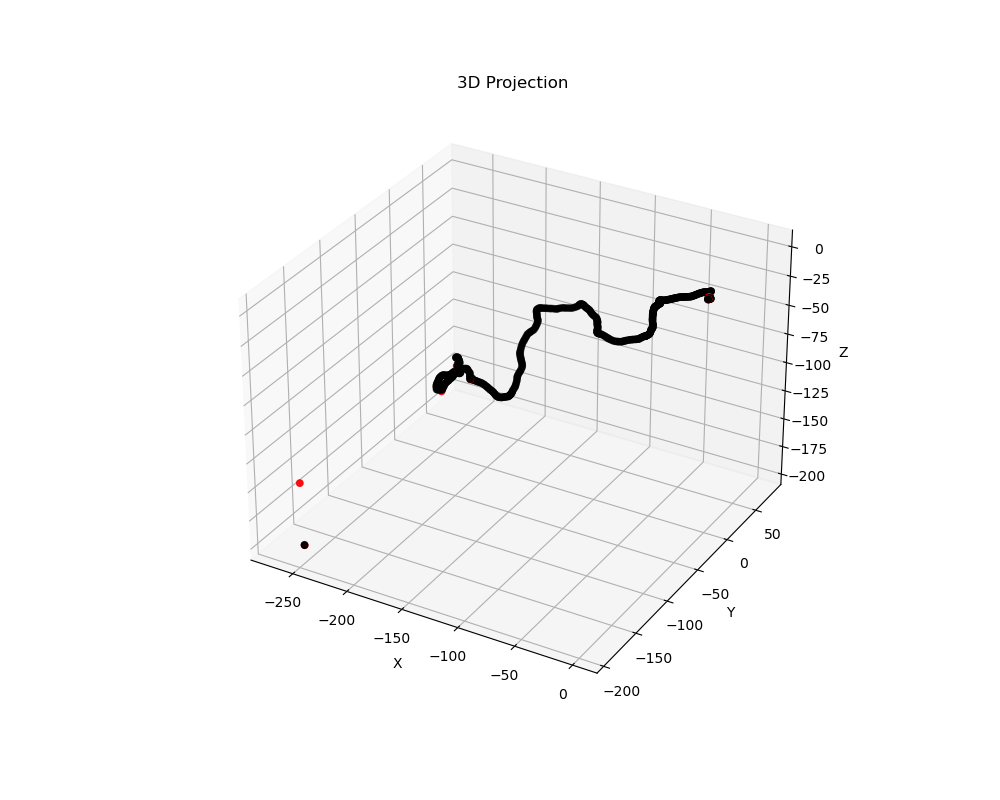

In [115]:
# Track building

# Function to walk along a track segment till we get to an end
def GetNodePath(graph, start_node, forward_node):
    path = [start_node]
    
    query = forward_node
    prev_node = start_node 

    for index,n in enumerate(range(len(graph))):

        path.append(query)
        
        # Get the connected nodes
        con_nodes = graph[query]

        # We hit a end-point and it didnt loop
        if (len(con_nodes) == 1):
            return path

        # Get the node that went in the query before
        if con_nodes[1] == prev_node:
            prev_node = query
            query = con_nodes[0]
        else:
            prev_node = query
            query = con_nodes[1]


    print("Error in pathing...")
    return path

def check_start_end_exists(number,Tracks):
    check_start = any(path["start"] == number for path in Tracks)
    check_end = any(path["end"] == number for path in Tracks)

    if (check_start or check_end):
        return True
    else:
        return False

# Function to calculate distance between two points
def calculate_distance(point1, point2):
    return np.sqrt((point2['x'] - point1['x'])**2 + (point2['y'] - point1['y'])**2 + (point2['z'] - point1['z'])**2)

# Get the length and energy of a track
def GetTrackLengthEnergy(path):
    total_length = 0
    total_energy = 0

    for t in range(len(path) - 1):
        point1 = data.iloc[path[t]]
        point2 = data.iloc[path[t + 1]]
        
        distance = calculate_distance(point1, point2)
        total_length += distance
        total_energy += point1['energy']
    
    # Add in the last energy hit
    total_energy += data.iloc[path[-1]]['energy']

    return round(total_length, 3), round(total_energy, 3)


# Get the length and energy of a track
def GetMeanNodeDist(Tracks):

    nodedists = []

    for track in Tracks:

        nodes = track["nodes"]
        if (len(nodes) == 1):
            continue

        for n in range(len(nodes) - 1):

            point1 = data.iloc[nodes[n]]
            point2 = data.iloc[nodes[n + 1]]
            
            distance = calculate_distance(point1, point2)
            nodedists.append(distance)

    return round(np.mean(nodedists), 3)


colormap = plt.cm.get_cmap('Dark2')
color_cycle = itertools.cycle(colormap.colors)

# Get indices where the value is 1
single_nodes = np.where(connection_count == 1)[0]

Tracks = []

for i,node in enumerate(single_nodes):
    # Check that the track hasnt already been added
    if (check_start_end_exists(node,Tracks)):
        continue

    # Get the track path
    path = GetNodePath(connected_nodes, node, connected_nodes[node][0])

    total_length, total_energy = GetTrackLengthEnergy(path)
    color = next(color_cycle)

    Track = {"id":i, "start":path[0], "end":path[-1], "nodes":path, "length":total_length, "energy":total_energy,"label":"track","c":color}
    Tracks.append(Track)

print(Tracks)

# Plot the labeled track
# Plot in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
colors = ['r' if count == 1 or count == 0 else 'k' for count in connection_count]
ax.scatter(data['x'], data['y'], data['z'], c=colors, marker='o')

for Track in Tracks:

    for i,connection in enumerate(Track["nodes"]):
            
            if (i == len(Track["nodes"])-1):
                break

            start_node = Track["nodes"][i]
            end_node = Track["nodes"][i+1]
   
            ax.plot([data['x'][start_node], data['x'][end_node]],
                    [data['y'][start_node], data['y'][end_node]],
                    [data['z'][start_node], data['z'][end_node]], color=Track["c"],linestyle="-")

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Projection')
plt.show()

# print(Tracks[1]["nodes"])
# print(GetNodePath(connected_nodes, 32, 27))
# print(GetNodePath(connected_nodes, 32, 41))

In [116]:
print(GetMeanNodeDist(Tracks))

dist_threshold = 4*GetMeanNodeDist(Tracks)
# dist_threshold = 10

0.655


0
Num new tracks: 5
Failed distance requirements
2
Num new tracks: 5
Failed distance requirements
4
Num new tracks: 5
6
Num new tracks: 5
Failed distance requirements
8
Num new tracks: 5
Total Tracks: 5
[{'id': 0, 'start': 0, 'end': 1, 'nodes': [0, 1], 'length': 0.202, 'energy': 0.029, 'label': 'track', 'c': (0.10588235294117647, 0.6196078431372549, 0.4666666666666667)}, {'id': 2, 'start': 2, 'end': 4, 'nodes': [2, 3, 5, 4], 'length': 1.06, 'energy': 0.113, 'label': 'track', 'c': (0.8509803921568627, 0.37254901960784315, 0.00784313725490196)}, {'id': 6, 'start': 101, 'end': 841, 'nodes': [101, 107, 116, 117, 113, 108, 104, 102, 97, 96, 98, 93, 90, 91, 81, 73, 70, 66, 75, 69, 72, 77, 76, 80, 78, 87, 79, 68, 64, 59, 57, 60, 67, 86, 92, 103, 111, 114, 120, 123, 125, 128, 129, 132, 134, 138, 136, 141, 144, 146, 148, 153, 157, 160, 163, 165, 171, 178, 182, 185, 191, 193, 199, 196, 192, 194, 189, 187, 181, 176, 169, 164, 161, 158, 154, 150, 147, 145, 142, 139, 137, 133, 130, 126, 122, 119, 1

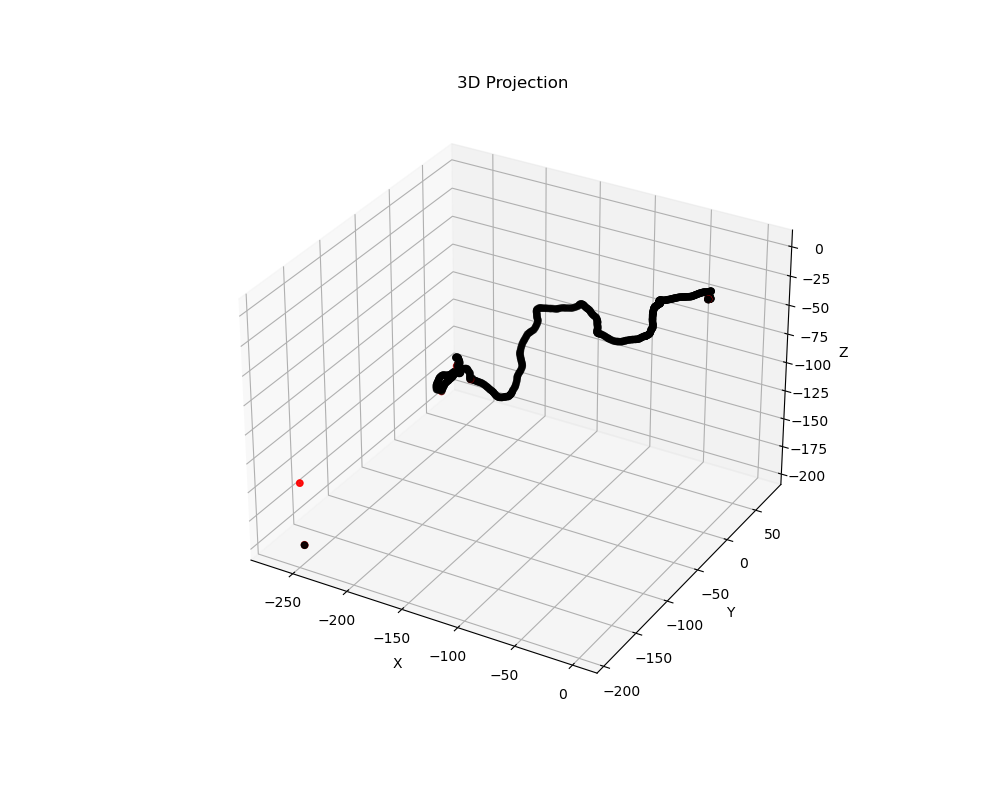

In [117]:
# Now look to merge tracks that are close by and identify deltas

def GetTrackwithNode(closest_idx, Tracks_):
    for t in Tracks_:
        if (closest_idx in t["nodes"]):
            return t["id"]
    # The node wasnt found anywhere...
    return -1

def GetTrackDictwithNode(closest_idx, Tracks_):
    for t in Tracks_:
        if (closest_idx in t["nodes"]):
            return t
    # The node wasnt found anywhere...
    return -1

def join_tracks(array1, array2):
    # Check if the arrays can be joined directly
    if array1[-1] == array2[0]:
        joined_array = array1 + array2[1:]
    elif array1[0] == array2[-1]:
        joined_array = array2 + array1[1:]
    # Check if reversing one of the arrays allows them to be joined
    elif array1[-1] == array2[-1]:
        array2_reversed = array2[::-1]
        joined_array = array1 + array2_reversed[1:]
    elif array1[0] == array2[0]:
        array1_reversed = array1[::-1]
        joined_array = array1_reversed + array2[1:]
    else:
        print("Error cannot join arrays")
        joined_array = array1 + array2  # If they can't be joined, just concatenate them

    return joined_array


def AddConnectedTracks(curr_track,conn_track, delta_path, seg1_path, seg2_path, UpdatedTracks):

    # Remove the old tracks from the array
    for index, t in enumerate(UpdatedTracks):
        
        # remove the old tracks
        if (t["id"] == curr_track):
            UpdatedTracks.pop(index)

    # Remove the old tracks from the array
    for index, t in enumerate(UpdatedTracks):
        # remove the old tracks
        if (t["id"] == conn_track):
            UpdatedTracks.pop(index)


    delta_len, delta_e = GetTrackLengthEnergy(delta_path)
    Delta = {"id":len(UpdatedTracks), "start":delta_path[0], "end":delta_path[-1], "nodes":delta_path, "length":delta_len, "energy":delta_e,"label":"delta","c":"darkred"}
    UpdatedTracks.append(Delta)
    
    joined_track_path = join_tracks(seg1_path, seg2_path)
    total_length_joined, total_energy_joined = GetTrackLengthEnergy(joined_track_path)
    color = next(color_cycle)
    
    Primary = {"id":len(UpdatedTracks), "start":joined_track_path[0], "end":joined_track_path[-1], "nodes":joined_track_path, "length":total_length_joined, "energy":total_energy_joined,"label":"track","c":color}
    UpdatedTracks.append(Primary)


# Update an existing track in the updated tracks array from the merging of two tracks
def UpdateAndMergeTrack(curr_track,conn_track, newpath, UpdatedTracks_):
    
    for index, t in enumerate(UpdatedTracks_):
        
        # Remove the old tracks from the array
        for index, t in enumerate(UpdatedTracks):
            
            # remove the old tracks
            if (t["id"] == curr_track):
                UpdatedTracks.pop(index)

        # Remove the old tracks from the array
        for index, t in enumerate(UpdatedTracks):
            # remove the old tracks
            if (t["id"] == conn_track):
                UpdatedTracks.pop(index)

    # Add the new merged track
    length, energy = GetTrackLengthEnergy(newpath)
    print(newpath[0], newpath[-1], newpath)
    color = next(color_cycle)
    Primary = {"id":len(UpdatedTracks_), "start":newpath[0], "end":newpath[-1], "nodes":newpath, "length":length, "energy":energy,"label":"track","c":color}
    UpdatedTracks_.append(Primary)


def SearchDelta(Track_, UpdatedTracks_):
    start = Track_["start"]
    end   = Track_["end"]

    for index, t in enumerate(UpdatedTracks_):
        
        # Check to see if the current track ends matches with any tracks in the updated and it is flagged as a delta
        if (t["start"] == start or t["start"] == end or t["end"] == start or t["end"] == end):
            if (t["label"] == "delta"):
                return True
        
    return False



# UpdatedTracks = []
UpdatedTracks = copy.deepcopy(Tracks)

# Keep tabs of tracks that have already been added
TrackCounter = []

for idx, Track in enumerate(Tracks):
    curr_track = Track["id"]
    print(curr_track)
    print("Num new tracks:", len(UpdatedTracks))
    
    start_node = Track["start"]
    end_node   = Track["end"]

    # Check if the start/end is in the UpdatedTracks and if it matches to a delta
    if (SearchDelta(Track, UpdatedTracks)):
        print("Track is flagged as a connected delta, skipping...")
        continue


    TrackCounter.append(Track["id"])

    # dont run this if we only got one track!
    if (len(Tracks) == 1):
        break

    # Get the indexes of closest nodes to start and end
    dist_ind_start = np.argsort(dist_matrix[start_node])[1:]
    dist_ind_end   = np.argsort(dist_matrix[end_node])[1:]

    # Filter nodes that are in the current track
    dist_ind_start = [x for x in dist_ind_start if x not in Track["nodes"]]
    dist_ind_end   = [x for x in dist_ind_end if x not in Track["nodes"]]

    # Distances of the end point to the closest track
    dist_start = dist_matrix[start_node][dist_ind_start[0]]
    dist_end   = dist_matrix[end_node][dist_ind_end[0]]

    # apply threshold
    if (dist_start > dist_threshold and dist_end > dist_threshold):
        print("Failed distance requirements")
        continue

    # Initialize
    closest_idx = 0
    end_conn_node = 0
    con_point = "start"
    curr_track_path = Track["nodes"]

    # Choose the smallest index
    if dist_start < dist_end:
        closest_idx = dist_ind_start[0]
        end_conn_node = start_node
        
    else:
        closest_idx = dist_ind_end[0]
        end_conn_node = end_node
        con_point = "end"

    # Get the track ID where the connecting node is located
    con_track      = GetTrackwithNode(closest_idx, Tracks)
    con_track_dict = GetTrackDictwithNode(closest_idx, Tracks)

    # if node-node then merge nodes and update track in Tracks
    if (closest_idx == con_track_dict["start"] or closest_idx == con_track_dict["end"]):
         
       newpath = join_tracks(curr_track_path,con_track_dict["nodes"])
       UpdateAndMergeTrack(curr_track, con_track, newpath, UpdatedTracks)
       UpdateConnections(closest_idx, end_conn_node, connected_nodes, connections, connection_count)
       continue


    # Check if the proposed connection will form a cycle
    # Temporarily add the connection to check for cycles
    temp_connections_dict = copy.deepcopy(connected_nodes)
    temp_connections      = copy.deepcopy(connections)
    temp_connection_count = copy.deepcopy(connection_count)

    UpdateConnections(end_conn_node, closest_idx, temp_connections_dict, temp_connections, temp_connection_count)

    # Check for cycles
    cycle = forms_cycle(end_conn_node, closest_idx, temp_connections_dict)

    temp_connections_dict = {}
    temp_connections = []
    temp_connection_count = []
    
    if not cycle:

        if (con_point =="start"):
            curr_track_path.insert(0,closest_idx)
        else:
            curr_track_path.append(closest_idx)

        Track["nodes"] = curr_track_path
        UpdateConnections(closest_idx, end_conn_node, connected_nodes, connections, connection_count)
    else:
        break

    # Get the length either side of track
    seg1_path = GetNodePath(connected_nodes, closest_idx, connected_nodes[closest_idx][0])
    seg2_path = GetNodePath(connected_nodes, closest_idx, connected_nodes[closest_idx][1])

    # Now get the lengths and energies of the track segments
    total_length_seg1, total_energy_seg1 = GetTrackLengthEnergy(seg1_path)
    total_length_seg2, total_energy_seg2 = GetTrackLengthEnergy(seg2_path) 
    total_length_seg3, total_energy_seg3 = GetTrackLengthEnergy(curr_track_path) 

    # Find the delta and the primary track and add them to the new track list
    if (total_length_seg1 < total_length_seg2 and total_length_seg1 < total_length_seg3):
        AddConnectedTracks(curr_track, con_track, seg1_path, seg2_path, curr_track_path, UpdatedTracks)
        TrackCounter.append(con_track)
    
    elif ((total_length_seg2 < total_length_seg1 and total_length_seg2 < total_length_seg3)):
        AddConnectedTracks(curr_track, con_track, seg2_path, seg1_path, curr_track_path, UpdatedTracks)
        TrackCounter.append(con_track)
    
    else:
        
        # Remove the old tracks from the array
        for j, t in enumerate(UpdatedTracks):
            
            # remove the old tracks
            if (t["id"] == curr_track):
                UpdatedTracks.pop(j)

        
        # Pop the track and re-add it with the new delta
        # UpdatedTracks.pop(idx)
        Delta = {"id":len(UpdatedTracks), "start":curr_track_path[0], "end":curr_track_path[-1], "nodes":curr_track_path, "length":total_length_seg3, "energy":total_energy_seg3,"label":"delta","c":"darkred"}
        UpdatedTracks.append(Delta)

print("Total Tracks:", len(UpdatedTracks))
print(UpdatedTracks)

# Seems like element 0 should have been poped...

# Plot the labeled track
# Plot in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
colors = ['r' if count == 1 or count == 0 else 'g' if count == 3 else 'k' for count in connection_count]
ax.scatter(data['x'], data['y'], data['z'], c=colors, marker='o')

for Track in UpdatedTracks:

    for i,connection in enumerate(Track["nodes"]):
            
            if (i == len(Track["nodes"])-1):
                break

            start_node = Track["nodes"][i]
            end_node = Track["nodes"][i+1]
   
            ax.plot([data['x'][start_node], data['x'][end_node]],
                    [data['y'][start_node], data['y'][end_node]],
                    [data['z'][start_node], data['z'][end_node]], color=Track["c"],linestyle="-")

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Projection')
plt.show()



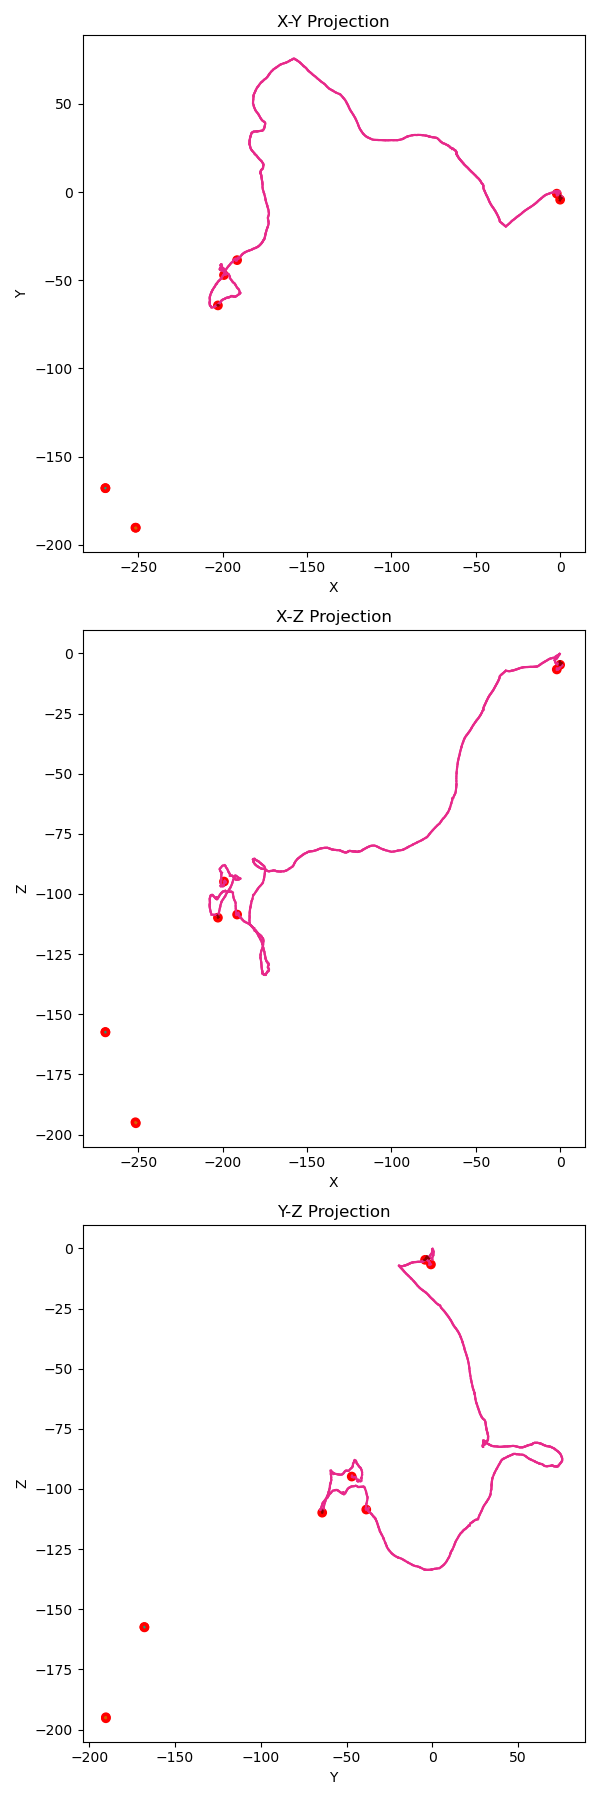

In [118]:
# Function to plot connections
def plot_connections(ax, x, y, connections, connection_count, x_label, y_label):
    # Filter data for markers with count 1 or 0
    filtered_indices = [i for i, count in enumerate(connection_count) if count == 1 or count == 0]
    filtered_x = [x[i] for i in filtered_indices]
    filtered_y = [y[i] for i in filtered_indices]
    
    # Define colors for filtered data
    colors = ['r' for count in filtered_indices]
    
    # Plot filtered markers
    ax.scatter(filtered_x, filtered_y, c=colors, marker='o')

    # Plot connections
    for Track in UpdatedTracks:
        for i, connection in enumerate(Track["nodes"]):
            if i == len(Track["nodes"]) - 1:
                break

            start_node = Track["nodes"][i]
            end_node = Track["nodes"][i + 1]

            ax.plot([x[start_node], x[end_node]],
                    [y[start_node], y[end_node]], color=Track["c"], linestyle="-")
    
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(f'{x_label}-{y_label} Projection')


# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(6, 18))

# Plot xy projection
plot_connections(axs[0], data['x'], data['y'], connections, connection_count, 'X', 'Y')

# Plot xz projection
plot_connections(axs[1], data['x'], data['z'], connections, connection_count, 'X', 'Z')

# Plot yz projection
plot_connections(axs[2], data['y'], data['z'], connections, connection_count, 'Y', 'Z')

plt.tight_layout()
plt.show()